In [1]:
import os
import random
import numpy as np
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import DataLoader
from src.train import train, plot_metrics
from src.models.attn_cond_eegnet_subjectFeatures import ConditionedEEGNet
from src.dataset.MI_dataset_single_subject import MI_Dataset
from src.dataset.MI_dataset_single_subject import MI_Dataset as single_subject_dataset
from config.over60 import cfg


from utils.eval import accuracy
from utils.model import print_parameters, print_weights_statistics

%load_ext autoreload
%autoreload 2


Calculate the average signal of each subect

Give this average to the model, to learn from it


In [2]:
###  Calculate USER AVERAGE FEATURE

subject_averages = {}
for subject_id in range(1, 10):
    print("Subject ID: ", subject_id)
    # TODO exclude test runs
    runs = cfg['data']['train_runs'][subject_id] + cfg['data']['test_runs'][subject_id]
    dataset = single_subject_dataset(cfg, subject_id, runs=runs)
    subject_average = np.average(dataset.X, axis=0)
    subject_averages[subject_id] = subject_average

Subject ID:  1
Subject ID:  2
Subject ID:  3
Subject ID:  4
Subject ID:  5
Subject ID:  6
Subject ID:  7
Subject ID:  8
Subject ID:  9


In [3]:
device =  torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
train_dataset = MI_Dataset.get_concat_dataset(cfg, split='train', return_subject_id = True, device=device, verbose=False)
train_dataloader = DataLoader(train_dataset, batch_size=cfg['train']['batch_size'], shuffle=True)
print(f"Train dataset: {len(train_dataset)} samples")

test_dataset = MI_Dataset.get_concat_dataset(cfg, split='test', return_subject_id = True, device=device, verbose=False)
test_dataloader = DataLoader(test_dataset, batch_size=cfg['train']['batch_size'], shuffle=False)
print(f"Test dataset: {len(test_dataset)} samples")

Loading dataset from cache\all_subjects_with_id_1-2-3-7-8\train_dataset.pkl...
Train dataset: 1200 samples
Loading dataset from cache\all_subjects_with_id_1-2-3-7-8\test_dataset.pkl...
Test dataset: 240 samples


In [5]:
model = ConditionedEEGNet.from_config(cfg['model'], subject_averages, device)
print_parameters(model)

eeg_encoder.conv1.weight........ --> 1024
eeg_encoder.bn1.weight.......... --> 16
eeg_encoder.bn1.bias............ --> 16
eeg_encoder.dw_conv1.weight..... --> 704
eeg_encoder.bn2.weight.......... --> 32
eeg_encoder.bn2.bias............ --> 32
eeg_encoder.sep_conv1.weight.... --> 512
eeg_encoder.conv2.weight........ --> 1024
eeg_encoder.bn3.weight.......... --> 32
eeg_encoder.bn3.bias............ --> 32
eeg_bn.embed.weight............. --> 768
eeg_norm.weight................. --> 384
eeg_norm.bias................... --> 384
eeg_dim_reduction.weight........ --> 6144
eeg_dim_reduction.bias.......... --> 16
subject_encoder.conv1.weight.... --> 1024
subject_encoder.bn1.weight...... --> 16
subject_encoder.bn1.bias........ --> 16
subject_encoder.dw_conv1.weight. --> 704
subject_encoder.bn2.weight...... --> 32
subject_encoder.bn2.bias........ --> 32
subject_encoder.sep_conv1.weight --> 512
subject_encoder.conv2.weight.... --> 1024
subject_encoder.bn3.weight...... --> 32
subject_encoder.bn3.bia

In [6]:
# Test forward pass
#model(*next(iter(train_dataloader))[0]);

In [7]:
loss, val_loss, train_acc, val_acc = train(model, train_dataloader, test_dataloader, cfg['train'])

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


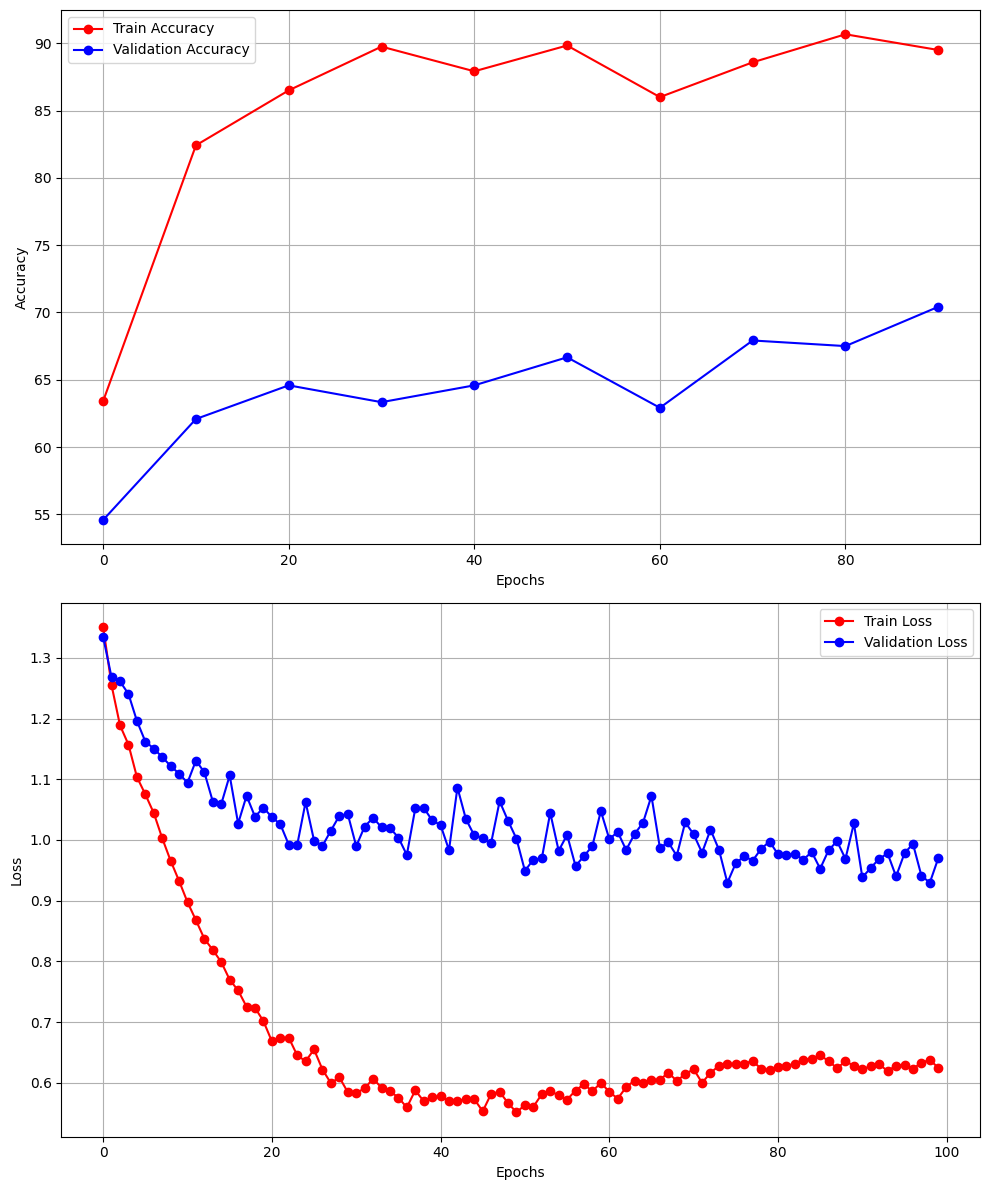

In [ ]:
plot_metrics(loss, val_loss, train_acc, val_acc)

In [ ]:
individual_results = [62, 60, 74, 78, 60]
average = sum(individual_results)/len(individual_results)
print(average)

66.8
